# Settings

In [1]:
import numpy as np
import pandas as pd

pd.set_option('max.colwidth', 500)

In [2]:
%reload_ext rpy2.ipython

# Scraping scripts

## Titles only

## Full article info

# Import data

In [1]:
import pandas as pd

titles = pd.read_csv("/Users/nancy/Documents/Github/medium_scrapy/raw/medium_titles_2019.csv")

full = pd.read_csv("/Users/nancy/Documents/Github/medium_scrapy/raw/medium_full_2019.csv")

In [2]:
print("Full:", full.shape)
print("Titles:", titles.shape)

Full: (37439, 9)
Titles: (49969, 2)


# Clean URL in full article data table

In [3]:
full['articleLink'] = full['articleURL'].str.split('?').str[0]

full.drop('articleURL', axis=1, inplace=True)

full.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(full.shape)

(28241, 9)


# Clean URL in titles data table

In [4]:
titles['articleLink'] = titles['articleURL'].str.split('?').str[0]

titles.drop('articleURL', axis=1, inplace=True)

titles.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(titles.shape)

(28244, 2)


# Merge two data tables to check for discrepancies

In [5]:
merged = full.merge(titles, how='outer', left_on='articleLink', right_on='articleLink' )

merged.drop(['article_x', 'article_y'], axis=1, inplace=True)

In [6]:
merged.columns

Index(['NumOfClaps', 'NumOfComments', 'articleTags', 'linkOfAuthorProfile',
       'nameOfAuthor', 'postingTime', 'readingTime', 'articleLink'],
      dtype='object')

In [8]:
merged.shape

(28264, 8)

# Parse URL slugs for title

In [9]:
## Remove NULLs in articleLink column 
merged.dropna(subset=['articleLink'], inplace=True)

In [10]:
for index, row in merged.iterrows():
    for link in row['articleLink'].split('/'):
        if '-' in link:
            words = link.split('-')[:-1]
            merged.loc[index, 'names'] = ' '.join(words)

In [20]:
merged.to_csv("/Users/nancy/Documents/Github/medium_scrapy/processed/2019_processed_titles.csv", index=None)

# Get title bigrams counts 

In [12]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import collections
import nltk
import spacy
from spacy_langdetect import LanguageDetector

#nlp = spacy.load('en_core_web_sm')

import en_core_web_lg
nlp = en_core_web_lg.load()

nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

counts = collections.Counter()

merged = pd.read_csv("/Users/nancy/Documents/Github/medium_scrapy/processed/2019_processed_titles.csv")

for sent in merged["names"]:
    doc = nlp(sent)
    if doc._.language['language'] == 'en':
        test1 = []
        for token in doc:
            if token.is_alpha:
                test1.append(token.text.lower())
    counts.update(nltk.bigrams(test1))

ModuleNotFoundError: No module named 'en_core_web_lg'

In [28]:
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()

df.columns = ["Bigrams", 'Count']

df[['Term1', 'Term2']] = pd.DataFrame(df['Bigrams'].tolist(), index=df.index)  

In [29]:
x = df[['Term1', 'Term2', 'Count']]

x.columns = ['word1', 'word2', 'n']

x.sort_values(by='n', ascending=False)

,word1,word2,n
0,data,science,2024
28,machine,learning,1486
318,how,to,797
147,a,data,483
382,data,scientist,433
195,of,data,356
328,for,data,352
304,in,the,343
1198,in,python,343
167,introduction,to,313


In [30]:
x.to_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2019_title_bigram_counts.csv", index=False)

# Visualize bigram relationships

In [6]:
%reload_ext rpy2.ipython

In [7]:
%%R 

library(igraph)

bigram_counts <- read.csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2019_title_bigram_counts.csv")

bigram_counts <- head(bigram_counts[order(-bigram_counts$n),], 60)

bigram_graph <- bigram_counts %>%
  graph_from_data_frame()

bigram_graph

IGRAPH 2fc34fd DN-- 54 60 -- 
+ attr: name (v/c), n (e/n)
+ edges from 2fc34fd (vertex names):
 [1] data        ->science      machine     ->learning    
 [3] how         ->to           a           ->data        
 [5] data        ->scientist    of          ->data        
 [7] for         ->data         in          ->the         
 [9] in          ->python       introduction->to          
[11] deep        ->learning     with        ->python      
[13] data        ->analysis     of          ->the         
[15] what        ->is           data        ->scientists  
+ ... omitted several edges


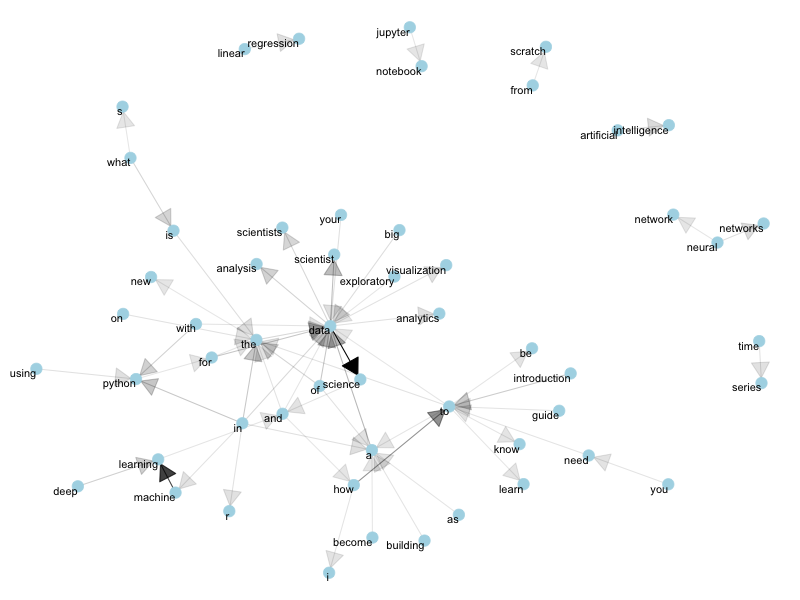

In [8]:
%%R -w 800 -h 600

library(ggraph)

set.seed(2016)

a <- grid::arrow(type = "closed")
        
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()